In [1]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *
from imcal import CalorimeterDataset
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import plot_conf_matrix

In [3]:
#variables controlled by the user. Change these to fit your specific needs.
TRAIN_N_EVENTS = 10000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
TEST_N_EVENTS = 3000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 50 #resolution

#Data specification
LABELS = ["BH_n5_M8", "SPH_9"] #for plotting
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FILENAMES = ["BH_n5_M8", "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"]
FOLDERS = ["BH", "sph"]
TRAIN_FILENAMES = [f"{name}_res{RES}_10000_events.h5" for name in FILENAMES]
TEST_FILENAMES = [f"{name}_test_res{RES}_3000_events.h5" for name in FILENAMES]
TRAIN_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TRAIN_FILENAMES[i]}" for i in range(CLASSES)] #The path to the folder containing the training histogram files
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)] #The path to the folder containing the testing histogram files

MODEL_NAME = f'resnet_{str(int(time.time()))}' #A unique name for the model
print(MODEL_NAME)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

#Data processing
#filters=["saturate", "normalise"]
filters=None
transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        #torchv.transforms.RandomHorizontalFlip(),
        RandomRoll(0),
        RandomRoll(1)
    )
#transforms=None

resnet_1669726326
Running on the GPU


In [4]:
#load data in memory
"""
trainpaths = [Path(TRAIN_DATAPATH/file) for file in TRAIN_FILENAMES]
testpaths = [Path(TEST_DATAPATH/file) for file in TEST_FILENAMES]
train_data = load_datasets(trainpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms)
test_data = load_datasets(testpaths, DEVICE, TEST_N_EVENTS, filters, transforms)"""

#load data lazily to not run out of memory, no method to load only part of the data yet
testpaths = [Path(path) for path in TEST_DATAPATHS]

test_data = Hdf5Dataset(testpaths, ["BH_n5_M8_test", "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test"], DEVICE, 
                        shuffle=False, filters=filters, transform=None, event_limit=TEST_N_EVENTS)

trainpaths = [Path(path) for path in TRAIN_DATAPATHS]
train_data = load_datasets(trainpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms)
#train_data = Hdf5Dataset(trainpaths, ["BH_n5_M8", "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"], DEVICE, 
                    #shuffle=True, transform=transforms, event_limit=TRAIN_N_EVENTS)

#print(torch.cuda.memory_summary(DEVICE=None, abbreviated=False))

Loads data with transforms Sequential(
  (0): RandomVerticalFlip(p=0.5)
  (1): RandomRoll()
  (2): RandomRoll()
) and filters None
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 17778.150390625.
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 13608.056640625.
Data has shape torch.Size([50, 50, 3])
There are 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[['BH_n5_M8', 'BH_n5_M8', 'BH_n5_M8', 'BH_n5_M8'], ['SPH_9', 'SPH_9', 'SPH_9', 'SPH_9']]
[[0, 0, 0, 0], [1, 1, 1, 1]]
[[38, 50, 49, 65], [3059, 3032, 3093, 3027]]
Image shape:  (50, 50, 3)


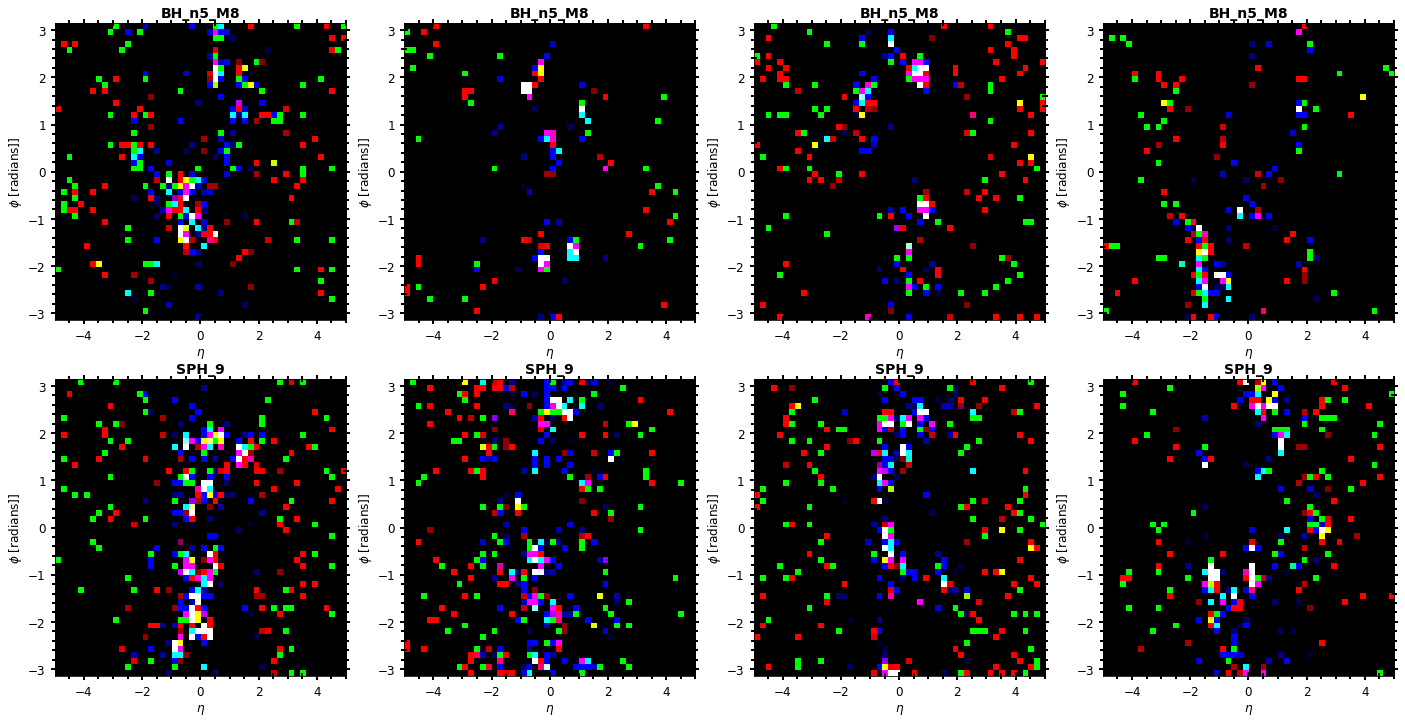

In [5]:
view_data(test_data, 4, CLASSES, LABELS, RES, TEST_N_EVENTS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 228.96054  337.287    355.99997  392.45975  500.9364  1116.8842
 1153.7877  2359.5205  2376.7854 ]
Looking at image 1675


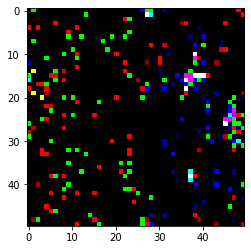

In [6]:
k = np.random.randint(0, len(train_data))
image = train_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


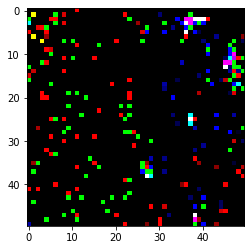

In [7]:
#Check augmentation
transforms = torch.nn.Sequential(
        #torchv.transforms.RandomVerticalFlip(),
        #torchv.transforms.RandomHorizontalFlip(),
        #RandomRoll(1),
        RandomRoll(0)
)
if transforms!=None:
    rolled_image = transforms(image)
    plt.imshow(rolled_image)

### Create net and train

In [8]:
#create NN and test that nothing major is wrong.
from resnet import ResNet18
resnet = ResNet18(img_channels=3, num_classes=CLASSES)
resnet.to(DEVICE)

#testimage, testlabel = traindata.images[0], traindata.img_labels[0]
testimage, testlabel = train_data[0][0], train_data[0][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)))

torch.Size([1, 3, 50, 50])
tensor([[ 0.9613, -0.3425]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [9]:
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, 0.0001, 0.01, cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001,step_size_up=5,mode="exp_range",gamma=0.85, cycle_momentum=False)
training_results = train(resnet, train_data, test_data, 2**8, 25, RES, DEVICE, optimizer, scheduler)

100%|██████████| 25/25 [03:10<00:00,  7.62s/it]


In [10]:
k = np.random.randint(0, len(test_data))
testimage, testlabel = test_data[k][0], test_data[k][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)), testlabel)

torch.Size([1, 3, 50, 50])
tensor([[0.7528, 0.2374]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([1., 0.], device='cuda:0', dtype=torch.float64)


(0.0, 0.7)

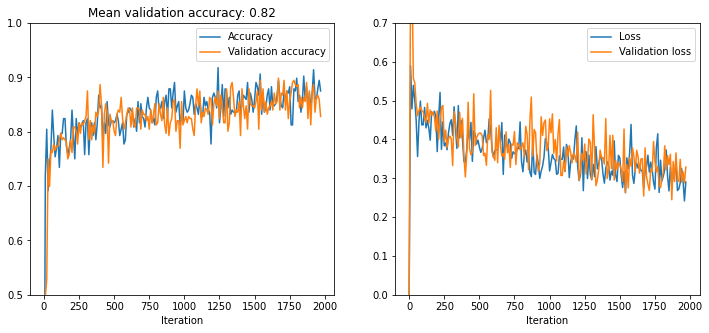

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
axs[0].set_ylim(0.5, 1)
axs[1].set_ylim(0, 0.7)

In [12]:
truth, preds = predict(resnet, test_data, 100, RES, DEVICE)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 60/60 [00:04<00:00, 14.04it/s]


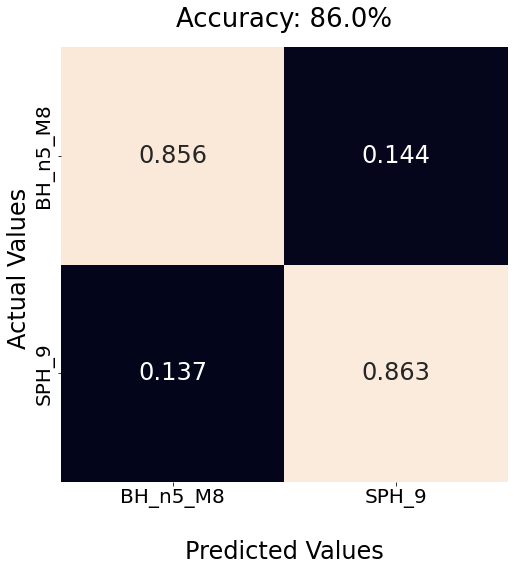

In [13]:
plot_conf_matrix(confusion, accuracy, LABELS)

In [14]:
print(torch.cuda.memory_summary(device=DEVICE, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  677046 KB |    1682 MB |    7450 GB |    7449 GB |
|       from large pool |  656064 KB |    1661 MB |    7338 GB |    7337 GB |
|       from small pool |   20982 KB |      40 MB |     112 GB |     112 GB |
|---------------------------------------------------------------------------|
| Active memory         |  677046 KB |    1682 MB |    7450 GB |    7449 GB |
|       from large pool |  656064 KB |    1661 MB |    7338 GB |